<a href="https://colab.research.google.com/github/veyselalevcan/Time_Series/blob/main/SARIMAX_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evds --upgrade
!pip install arch
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import evds as ev
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
evds=ev.evdsAPI('J2ua6jVeIF')
dolar= evds.get_data(['TP.DK.USD.S.YTL'], startdate='01-01-2010', enddate='01-01-2024', frequency=5)
endeks= evds.get_data(['TP.MK.F.BILESIK'], startdate='01-01-2010', enddate='01-01-2024', frequency=5)
tufe= evds.get_data(['TP.FG.J0'], startdate='01-01-2010', enddate='01-01-2024', frequency=5)

In [ ]:
len(dolar), len(endeks), len(tufe)

(166, 166, 166)

# Tum buyuklukler esit olmalı bu sebeple dolar endeksten son verileri siliyoruz

In [ ]:
dolar= dolar.iloc[:-1]
endeks= endeks.iloc[:-1]

In [ ]:
dolar.rename(columns={dolar.columns[1]: 'Dolar/TL'}, inplace=True)
endeks.rename(columns={endeks.columns[1]: 'BIST100'}, inplace=True)
tufe.rename(columns={tufe.columns[1]: 'Tufe'}, inplace=True)

In [ ]:
veri= pd.DataFrame()
veri['Dolar/TL']= dolar['Dolar/TL']
veri['BIST100']= endeks['BIST100']
veri['Tufe']= tufe['Tufe']
veri

,Dolar/TL,BIST100,Tufe
0,1.473400,540.28,174.07
1,1.512830,493.84,176.59
2,1.535678,569.89,177.62
3,1.495048,587.63,178.68
4,1.542210,540.34,178.04
...,...,...,...
161,23.106042,5759.11,1351.59
162,26.470338,7216.96,1479.84
163,26.999127,7917.93,1614.31
164,26.989448,8334.94,1691.04


In [ ]:
tarih= pd.date_range(start= '01.01.2010', periods= len(veri), freq='M')
veri['Tarih']= tarih

In [ ]:
veri.set_index('Tarih', inplace= True)
veri

,Dolar/TL,BIST100,Tufe
Tarih,,,
2010-01-31,1.473400,540.28,174.07
2010-02-28,1.512830,493.84,176.59
2010-03-31,1.535678,569.89,177.62
2010-04-30,1.495048,587.63,178.68
2010-05-31,1.542210,540.34,178.04
...,...,...,...
2023-06-30,23.106042,5759.11,1351.59
2023-07-31,26.470338,7216.96,1479.84
2023-08-31,26.999127,7917.93,1614.31


In [ ]:
veri.isnull().sum()

Dolar/TL    0
BIST100     0
Tufe        0
dtype: int64

# Endeks tahmin etmek istiyoruz hdef degiskenim Bıst 100


In [ ]:
veri.corr()

,Dolar/TL,BIST100,Tufe
Dolar/TL,1.000000,0.938004,0.994536
BIST100,0.938004,1.000000,0.956415
Tufe,0.994536,0.956415,1.000000


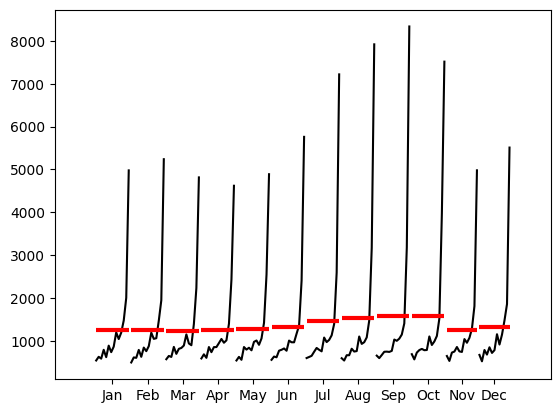

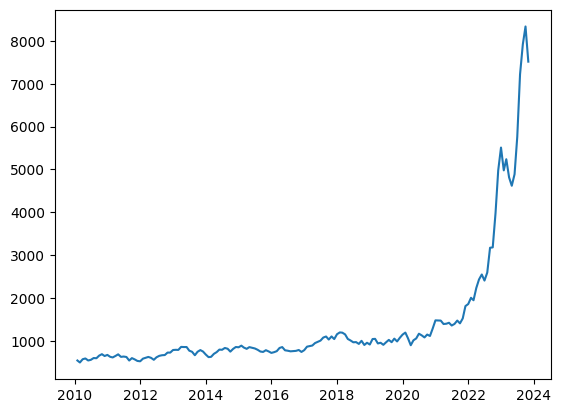

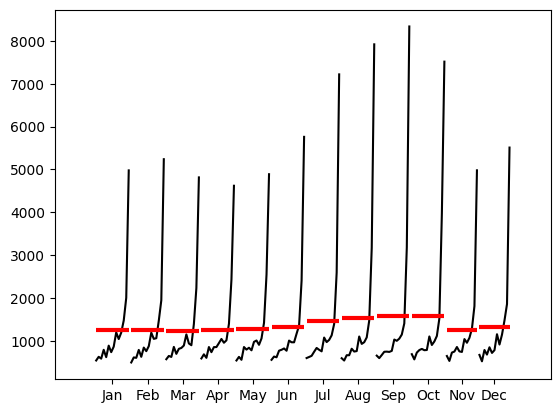

In [ ]:
plt.plot(veri['BIST100'])
month_plot(veri['BIST100'])

In [ ]:
adf= ADF(veri['BIST100'])
kpss= KPSS(veri['BIST100'])
adf, kpss

(<class 'arch.unitroot.unitroot.ADF'>
 """
    Augmented Dickey-Fuller Results   
 Test Statistic                  2.049
 P-value                         0.999
 Lags                               14
 -------------------------------------
 
 Trend: Constant
 Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """,
 <class 'arch.unitroot.unitroot.KPSS'>
 """
     KPSS Stationarity Test Results   
 Test Statistic                  1.001
 P-value                         0.002
 Lags                                8
 -------------------------------------
 
 Trend: Constant
 Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
 Null Hypothesis: The process is weakly stationary.
 Alternative Hypothesis: The process contains a unit root.
 """)

In [ ]:
fark= veri['BIST100'].diff().dropna() # 1. cil fark
fark

Tarih
2010-02-28     -46.44
2010-03-31      76.05
2010-04-30      17.74
2010-05-31     -47.29
2010-06-30      15.52
               ...   
2023-06-30     872.20
2023-07-31    1457.85
2023-08-31     700.97
2023-09-30     417.01
2023-10-31    -820.84
Name: BIST100, Length: 165, dtype: float64

In [ ]:
adf= ADF(fark)
kpss= KPSS(fark)
adf, kpss

(<class 'arch.unitroot.unitroot.ADF'>
 """
    Augmented Dickey-Fuller Results   
 Test Statistic                 -0.517
 P-value                         0.889
 Lags                               14
 -------------------------------------
 
 Trend: Constant
 Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """,
 <class 'arch.unitroot.unitroot.KPSS'>
 """
     KPSS Stationarity Test Results   
 Test Statistic                  0.765
 P-value                         0.009
 Lags                                2
 -------------------------------------
 
 Trend: Constant
 Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
 Null Hypothesis: The process is weakly stationary.
 Alternative Hypothesis: The process contains a unit root.
 """)

In [ ]:
fark= veri['BIST100'].diff().diff().dropna() # 2. cil fark ile duraganlasmayı gorduk
fark

Tarih
2010-03-31     122.49
2010-04-30     -58.31
2010-05-31     -65.03
2010-06-30      62.81
2010-07-31      25.93
               ...   
2023-06-30     603.22
2023-07-31     585.65
2023-08-31    -756.88
2023-09-30    -283.96
2023-10-31   -1237.85
Name: BIST100, Length: 164, dtype: float64

In [ ]:
adf= ADF(fark)
kpss= KPSS(fark)
adf, kpss

In [ ]:
tscv= TimeSeriesSplit(n_splits=5) #Capraz dogrulama tanımlama

In [ ]:
# hata tanımlayacak fn
def hata(y, tahmin):
  mse= mean_squared_error(y,tahmin)
  rmse= np.sqrt(mean_squared_error(y,tahmin))
  mae= mean_absolute_error(y, tahmin)
  return mse,rmse, mae

In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  model= Holt(train).fit(optimized= True, use_brute= True)
  tahmin= model.forecast(len(test))
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('Holt Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

Holt Model MSE: 1939019.3860445302 RMSE: 765.622709184395 MAE: 595.0266911193721


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  model= ExponentialSmoothing(train, trend= 'add',
                              seasonal='add',
                              seasonal_periods=12).fit(optimized= True, use_brute= True)
  tahmin= model.forecast(len(test))
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('Holt Winters Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

Holt Winters Model MSE: 2101279.1742902948 RMSE: 770.719536299652 MAE: 600.2043836747632


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  model= auto_arima(train, trace= False, seasonal= False)
  tahmin= model.predict(len(test))
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('ARIMA Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

ARIMA Model MSE: 2196091.6208284358 RMSE: 793.3570225536322 MAE: 623.0641147193944


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  model= auto_arima(train, trace= False, seasonal= True, m=12)
  tahmin= model.predict(len(test))
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('SARIMA Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

SARIMA Model MSE: 2133837.9745421996 RMSE: 785.6180883023314 MAE: 614.3573777066155


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  trainexog, testexog =veri['Dolar/TL'].iloc[train_indeks], veri['Dolar/TL'].iloc[test_indeks]
  trainexog= np.array(trainexog).reshape(-1,1)
  testexog= np.array(testexog).reshape(-1,1)
  model= auto_arima(train, trace= False, seasonal= False, X=trainexog)
  tahmin= model.predict(len(test), X=testexog)
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('ARIMAX1 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

ARIMAX1 Model MSE: 2881051.832858058 RMSE: 981.8283042598526 MAE: 795.4109746257551


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  trainexog, testexog =veri['Tufe'].iloc[train_indeks], veri['Tufe'].iloc[test_indeks]
  trainexog= np.array(trainexog).reshape(-1,1)
  testexog= np.array(testexog).reshape(-1,1)
  model= auto_arima(train, trace= False, seasonal= False, X=trainexog)
  tahmin= model.predict(len(test), X=testexog)
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('ARIMAX2 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

ARIMAX2 Model MSE: 927524.1825537554 RMSE: 532.5605962325537 MAE: 400.0208726003193


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  trainexog, testexog =veri['Dolar/TL'].iloc[train_indeks], veri['Dolar/TL'].iloc[test_indeks]
  trainexog= np.array(trainexog).reshape(-1,1)
  testexog= np.array(testexog).reshape(-1,1)
  model= auto_arima(train, trace= False, seasonal= True, m=12, X=trainexog)
  tahmin= model.predict(len(test), X=testexog)
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('SARIMAX1 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

SARIMAX1 Model MSE: 2724991.2114773714 RMSE: 951.580436331035 MAE: 767.5421232456792


In [ ]:
mse=[]
rmse=[]
mae= []

for train_indeks, test_indeks in tscv.split(veri['BIST100']):
  train, test =veri['BIST100'].iloc[train_indeks], veri['BIST100'].iloc[test_indeks]
  trainexog, testexog =veri['Tufe'].iloc[train_indeks], veri['Tufe'].iloc[test_indeks]
  trainexog= np.array(trainexog).reshape(-1,1)
  testexog= np.array(testexog).reshape(-1,1)
  model= auto_arima(train, trace= False, seasonal= True, m=12, X=trainexog)
  tahmin= model.predict(len(test), X=testexog)
  hatason= hata(test, tahmin)
  mse.append(hatason[0])
  rmse.append(hatason[1])
  mae.append(hatason[2])

print('SARIMAX2 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

SARIMAX2 Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544


In [ ]:
print('Holt Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('Holt Winters Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('ARIMA Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('SARIMA Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('ARIMAX1 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('ARIMAX2 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('SARIMAX1 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))
print('SARIMAX2 Model MSE: {} RMSE: {} MAE: {}'.format(np.mean(mse), np.mean(rmse), np.mean(mae)))

Holt Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
Holt Winters Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
ARIMA Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
SARIMA Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
ARIMAX1 Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
ARIMAX2 Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
SARIMAX1 Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544
SARIMAX2 Model MSE: 921193.6379535882 RMSE: 542.1347603197952 MAE: 409.21487326101544


In [ ]:
model1= Holt(veri['BIST100']).fit(optimized= True, use_brute= True)
model2= ExponentialSmoothing(veri['BIST100'], trend= 'add',
                              seasonal='add',
                              seasonal_periods=2).fit(optimized= True, use_brute= True)
model3= auto_arima(veri['BIST100'], trace= False,
                   seasonal= False, X= np.array(veri['Tufe']).reshape(-1,1))
model4= auto_arima(veri['BIST100'], trace= False,
                   seasonal= True, m=7, X= np.array(veri['Tufe']).reshape(-1,1)) #m=7 en dusuk aic degeri

In [ ]:
for i in range(1,13):
  smodel= auto_arima(veri['BIST100'], trace= False,
                   seasonal= True, m=i, X= np.array(veri['Tufe']).reshape(-1,1))
  print(' m {} aic degeri {}'.format(i, smodel.aic()))

 m 1 aic degeri 2156.202303563209
 m 2 aic degeri 2202.4070892389627
 m 3 aic degeri 2161.269878331659
 m 4 aic degeri 2188.1607490034385
 m 5 aic degeri 2145.848406327404
 m 6 aic degeri 2163.5774027409507
 m 7 aic degeri 2077.577688474219
 m 8 aic degeri 2160.023140796921
 m 9 aic degeri 2155.5303341785475


KeyboardInterrupt: ignored

In [ ]:
model4= auto_arima(veri['BIST100'], trace= False,
                   seasonal= True, m=7, d=1, X= np.array(veri['Tufe']).reshape(-1,1)) #m=7 en dusuk aic degeri
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  166
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -1019.230
Date:                           Mon, 27 Nov 2023   AIC                           2058.460
Time:                                   20:24:18   BIC                           2089.086
Sample:                               01-31-2010   HQIC                          2070.897
                                    - 10-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2111      0.386      5.730      0.000       1.455       2.967
ar.L1          1.5227      0.065     23.312      0.000       1.395       1.651
ar.L2         -0.9995      0.027    -37.261      0.000      -1.052      -0.947
ma.L1         -1.2536      0.078    -16.164      0.000      -1.406      -1.102
ma.L2          0.6691      0.049     13.536      0.000       0.572       0.766
ar.S.L7       -0.2607      0.331     -0.788      0.431      -0.909       0.388
ar.S.L14      -0.1338      0.256     -0.523      0.601      -0.635       0.367
ma.S.L7       -0.0915      0.284     -0.322      0.747      -0.649       0.466
ma.S.L14      -0.6746      0.216     -3.116      0.002      -1.099      -0.250
sigma2      2.253e+04   2301.708      9.787      0.000     1.8e+04     2.7e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):               287.61
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):              15.39   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# P>0.05 olanları cıkartacagım yeni bir model kuruyorum:
model4 = SARIMAX(veri['BIST100'], exog= veri['Tufe'], order=(2,1,2), seasonal_order=(0,1,[2],7))
model4son= model4.fit()
model4son.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           BIST100   No. Observations:                  166
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1022.329
Date:                           Mon, 27 Nov 2023   AIC                           2058.658
Time:                                   20:30:57   BIC                           2080.097
Sample:                               01-31-2010   HQIC                          2067.365
                                    - 10-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Tufe           1.1893      0.276      4.309      0.000       0.648       1.730
ar.L1          1.6028      0.029     55.317      0.000       1.546       1.660
ar.L2         -0.9997      0.016    -64.293      0.000      -1.030      -0.969
ma.L1         -1.4496      0.073    -19.855      0.000      -1.593      -1.306
ma.L2          0.7391      0.051     14.507      0.000       0.639       0.839
ma.S.L14      -0.6525      0.065    -10.050      0.000      -0.780      -0.525
sigma2      2.249e+04   1645.723     13.669      0.000    1.93e+04    2.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                99.19
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              12.69   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
q= acorr_ljungbox(model4son.resid)
q

,lb_stat,lb_pvalue
1,0.491058,0.483456
2,0.498614,0.779341
3,3.710282,0.294496
4,3.732786,0.443375
5,3.926096,0.560105
6,8.080244,0.232283
7,12.493228,0.085462
8,13.997676,0.081826
9,24.020556,0.004269
10,28.773902,0.001355


In [ ]:
tahmin1= model1.predict(start=veri.index[0], end= veri.index[len(veri)-1])
tahmin2= model2.predict(start=veri.index[0], end= veri.index[len(veri)-1])
tahmin3= model4son.predict(exog= veri['Tufe'],start=veri.index[0], end= veri.index[len(veri)-1])

In [ ]:
df= pd.DataFrame()
df['BIST100']= veri['BIST100']
df['Holt Model Tahmin']= tahmin1
df['Holt Winters Tahmin']= tahmin2
df['SARIMAX Tahmin']= tahmin3
df

,BIST100,Holt Model Tahmin,Holt Winters Tahmin,SARIMAX Tahmin
Tarih,,,,
2010-01-31,540.28,493.840000,585.338421,207.020462
2010-02-28,493.84,496.891854,568.663410,760.174118
2010-03-31,569.89,450.483498,469.803837,296.429267
2010-04-30,587.63,534.365165,599.385397,484.082599
2010-05-31,540.34,556.202554,567.847409,509.799256
...,...,...,...,...
2023-06-30,5759.11,5011.100547,4978.288035,5835.880414
2023-07-31,7216.96,5933.222670,5944.264628,6802.849247
2023-08-31,7917.93,7479.174891,7451.759899,7709.997550


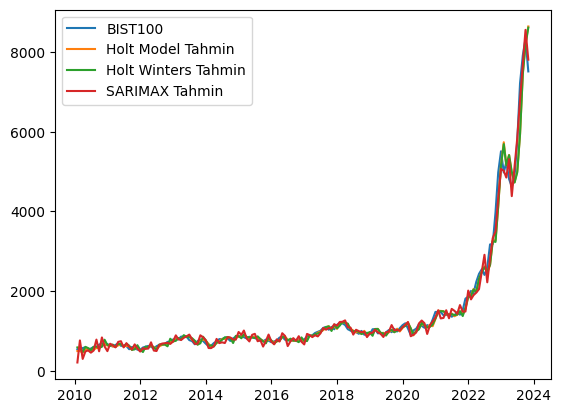

In [ ]:
plt.plot(df)
plt.legend(df.columns)
plt.show()